## Redes Neurais Adversativas (GANs)

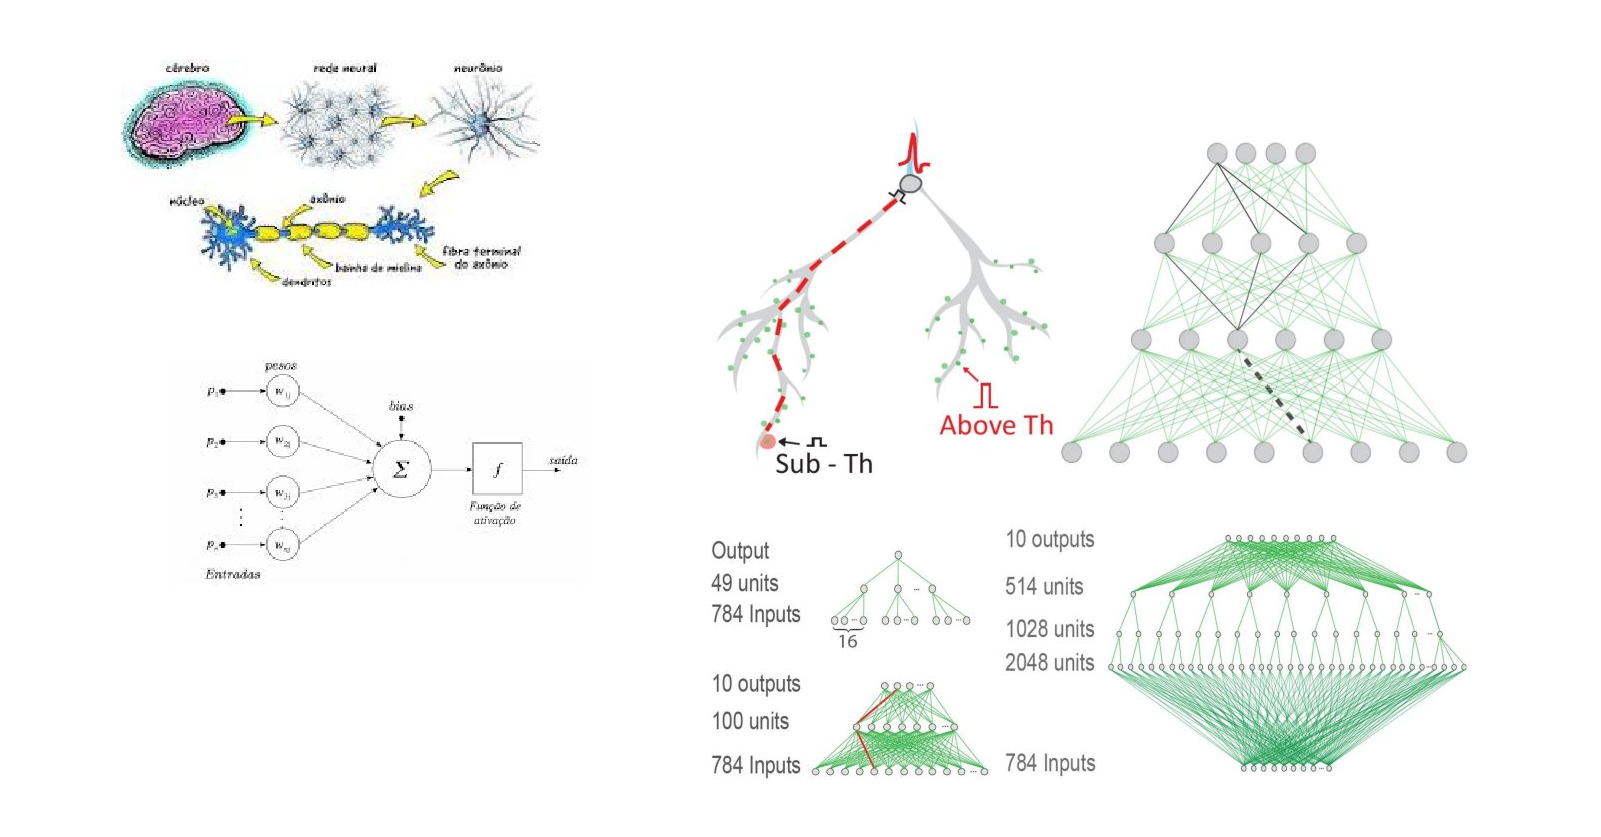

- As redes adversárias generativas (GANs) são um tipo de modelo de aprendizado de máquina introduzido por Ian Goodfellow em 2014, composto por duas redes neurais que competem entre si: o gerador e o discriminador.


- O gerador cria dados sintéticos que se assemelham a dados reais, enquanto o discriminador tenta distinguir entre dados reais e gerados.


- A interação adversarial entre as duas redes leva o gerador a produzir dados cada vez mais realistas, tornando as GANs particularmente eficazes em tarefas de geração de imagens, melhoria de resolução, e criação de conteúdo em diversas áreas, incluindo arte, música, e pesquisa médica.

###Descrição do Modelo


- Este modelo de redes adversárias generativas (GAN) é projetado para gerar novas imagens que imitam um conjunto de dados original.


- O gerador cria imagens falsas a partir de ruído aleatório, enquanto o discriminador tenta identificar se uma imagem é real (do conjunto de dados) ou falsa (gerada).



- O treinamento adversarial contínuo melhora a qualidade das imagens geradas até que se tornem indistinguíveis das imagens reais.



- Esta abordagem tem se mostrado eficaz para várias aplicações, incluindo a criação de imagens de alta qualidade e a geração de dados sintéticos para aumentar conjuntos de dados de treinamento.

### Conectando com o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Instalações necessárias

In [ ]:
# Instalar TensorFlow (caso não esteja instalado ou precise de uma versão específica)
!pip install tensorflow

# Instalar matplotlib (para a geração e visualização de gráficos)
!pip install matplotlib

11490434/11490434 [==============================] - 0s 0us/step


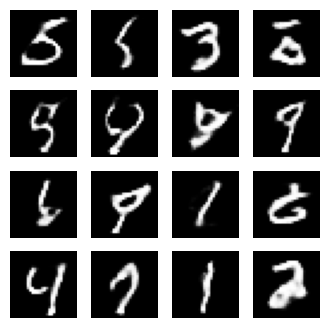

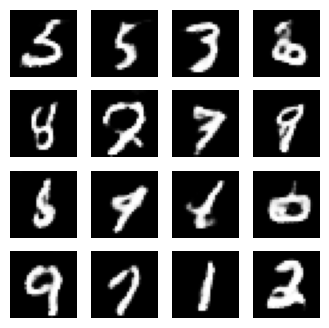

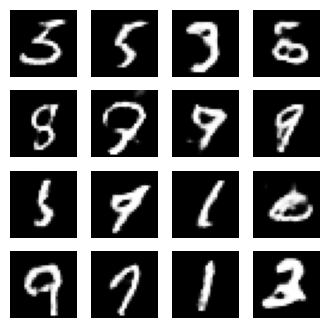

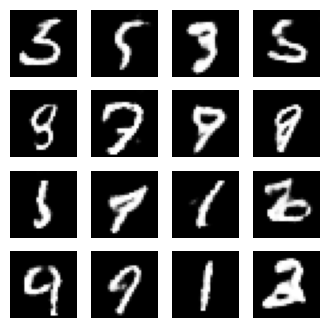

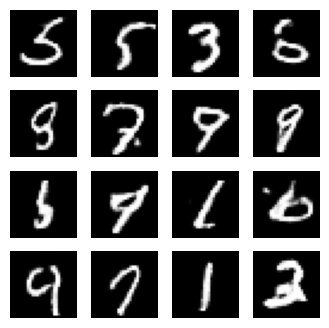

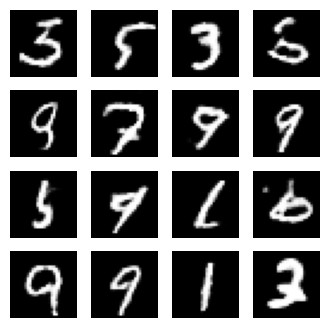

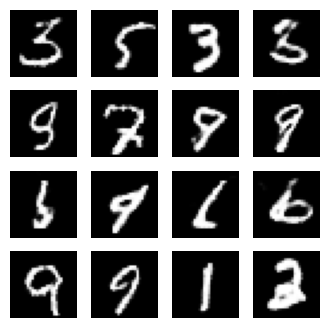

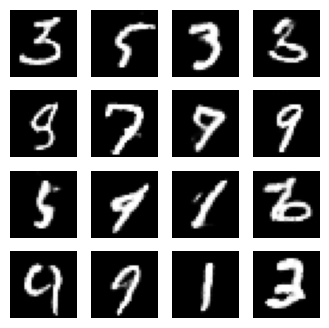

In [ ]:
# Importar bibliotecas necessárias
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Carregar e pré-processar os dados
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()  # Carrega as imagens de treino do dataset MNIST. Os rótulos são ignorados.

train_images = (train_images.astype('float32') - 127.5) / 127.5
# Converte as imagens para float32 e normaliza os valores para o intervalo [-1, 1].

train_images = np.expand_dims(train_images, axis=-1)
# Adiciona uma dimensão extra para representar os canais de cor, transformando cada imagem de (28, 28) para (28, 28, 1).

def make_generator_model():
    """
    Cria e retorna o modelo gerador.

    O gerador começa com um vetor latente de dimensão 100 e o transforma em uma imagem 28x28x1 através de camadas densas
    e convolucionais transpostas. Cada camada é seguida por normalização em batch e uma ativação LeakyReLU, exceto
    a última camada, que usa a ativação tanh para mapear a saída para o intervalo [-1, 1].
    """
    model = models.Sequential()  # Inicializa um modelo sequencial.

    # Camada densa com 7*7*256 unidades, sem viés, input shape de (100,)
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    # Normaliza a saída da camada anterior.
    model.add(layers.BatchNormalization())
    # Aplica a função de ativação LeakyReLU.
    model.add(layers.LeakyReLU())

    # Transforma a saída 1D em um tensor 3D com forma (7, 7, 256).
    model.add(layers.Reshape((7, 7, 256)))

    # Camada deconvolucional (Conv2DTranspose) com 128 filtros, kernel 5x5, stride 1x1, sem viés e padding 'same'.
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Normaliza a saída da camada anterior.
    model.add(layers.BatchNormalization())
    # Aplica a função de ativação LeakyReLU.
    model.add(layers.LeakyReLU())

    # Camada deconvolucional com 64 filtros, kernel 5x5, stride 2x2, sem viés e padding 'same'.
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Normaliza a saída da camada anterior.
    model.add(layers.BatchNormalization())
    # Aplica a função de ativação LeakyReLU.
    model.add(layers.LeakyReLU())

    # Camada deconvolucional final com 1 filtro, kernel 5x5, stride 2x2, sem viés, padding 'same' e ativação 'tanh'.
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model  # Retorna o modelo do gerador.

def make_discriminator_model():
    """
    Cria e retorna o modelo discriminador.

    O discriminador recebe uma imagem 28x28x1 e retorna uma única unidade (logit) que representa a probabilidade
    de a imagem ser real. Ele consiste em camadas convolucionais seguidas por LeakyReLU e dropout para robustez.
    """
    model = models.Sequential()  # Inicializa um modelo sequencial.

    # Camada convolucional com 64 filtros, kernel 5x5, stride 2x2, input shape (28, 28, 1) e padding 'same'.
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    # Aplica a função de ativação LeakyReLU.
    model.add(layers.LeakyReLU())
    # Aplica dropout para prevenir overfitting.
    model.add(layers.Dropout(0.3))

    # Camada convolucional com 128 filtros, kernel 5x5, stride 2x2 e padding 'same'.
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # Aplica a função de ativação LeakyReLU.
    model.add(layers.LeakyReLU())
    # Aplica dropout para prevenir overfitting.
    model.add(layers.Dropout(0.3))

    # Achata a saída da camada anterior.
    model.add(layers.Flatten())
    # Camada densa final com uma unidade (logit).
    model.add(layers.Dense(1))

    return model  # Retorna o modelo do discriminador.

# Definir a função de perda e otimizadores
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define a função de perda de entropia cruzada binária, que mede a diferença entre as distribuições de probabilidade real e predita.

def discriminator_loss(real_output, fake_output):
    """
    Calcula e retorna a perda do discriminador.

    A perda do discriminador é a soma das perdas para as saídas reais e falsas.
    A perda real é calculada comparando a saída do discriminador para imagens reais com um tensor de '1s',
    enquanto a perda falsa é calculada comparando a saída do discriminador para imagens falsas com um tensor de '0s'.

    Parameters:
        real_output (tensor): Saída do discriminador para imagens reais.
        fake_output (tensor): Saída do discriminador para imagens falsas.

    Returns:
        tensor: A perda total do discriminador.
    """
    # Calcula a perda para saídas reais.
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # Calcula a perda para saídas falsas.
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # Soma as perdas reais e falsas para obter a perda total do discriminador.
    total_loss = real_loss + fake_loss
    return total_loss  # Retorna a perda total do discriminador.

def generator_loss(fake_output):
    """
    Calcula e retorna a perda do gerador.

    A perda do gerador é calculada comparando a saída do discriminador para imagens geradas (falsas) com um tensor de '1s',
    incentivando o gerador a criar imagens que o discriminador classifica como reais.

    Parameters:
        fake_output (tensor): Saída do discriminador para imagens falsas.

    Returns:
        tensor: A perda do gerador.
    """
    # Calcula a perda do gerador.
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define os otimizadores para gerador e discriminador
generator_optimizer = tf.keras.optimizers.Adam(1e-4)  # Otimizador Adam para o gerador com taxa de aprendizado de 1e-4.
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)  # Otimizador Adam para o discriminador com taxa de aprendizado de 1e-4.

# Definir o treinamento
EPOCHS = 100  # Número de épocas para o treinamento.
BATCH_SIZE = 256  # Tamanho do batch para o treinamento.
noise_dim = 100  # Dimensão do vetor de ruído que será a entrada do gerador.
num_examples_to_generate = 16  # Número de exemplos a serem gerados após cada época.
seed = tf.random.normal([num_examples_to_generate, noise_dim])  # Semente fixa para geração de exemplos consistentes para visualização.

# Cria as instâncias do gerador e do discriminador
generator = make_generator_model()  # Inicializa o modelo gerador.
discriminator = make_discriminator_model()  # Inicializa o modelo discriminador.

@tf.function  # Decorador para otimizar a função com TensorFlow.
def train_step(images):
    """
    Executa um passo de treinamento para o gerador e o discriminador.

    Esta função gera um vetor de ruído aleatório para criar imagens falsas com o gerador, avalia as imagens reais e falsas
    com o discriminador, calcula as perdas e atualiza os pesos dos modelos com base nos gradientes.

    Parameters:
        images (tensor): Batch de imagens reais usado para treinar o discriminador.
    """
    # Gera um batch de vetores de ruído aleatórios.
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Inicializa fitas de gradiente para gerador e discriminador.

        generated_images = generator(noise, training=True)
        # Gera imagens a partir do ruído usando o gerador.

        real_output = discriminator(images, training=True)
        # Avalia imagens reais com o discriminador.

        fake_output = discriminator(generated_images, training=True)
        # Avalia imagens geradas com o discriminador.

        gen_loss = generator_loss(fake_output)
        # Calcula a perda do gerador.

        disc_loss = discriminator_loss(real_output, fake_output)
        # Calcula a perda do discriminador.

    # Calcula os gradientes da perda do gerador em relação às suas variáveis treináveis.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Calcula os gradientes da perda do discriminador em relação às suas variáveis treináveis.
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Aplica os gradientes calculados para atualizar os pesos do gerador.
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # Aplica os gradientes calculados para atualizar os pesos do discriminador.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    """
    Treina a GAN por um número especificado de épocas.

    Esta função itera sobre cada época e cada batch de imagens no dataset,
    executando o passo de treinamento para atualizar os pesos do gerador e do discriminador.

    Parameters:
        dataset (tf.data.Dataset): Dataset de treino.
        epochs (int): Número de épocas para treinar o modelo.
    """
    for epoch in range(epochs):  # Itera sobre o número de épocas.
        for image_batch in dataset:  # Itera sobre cada batch de imagens no dataset.
            train_step(image_batch)  # Executa um passo de treinamento para cada batch.

def generate_and_save_images(model, epoch, test_input):
    """
    Gera e salva imagens usando o modelo gerador.

    Esta função usa o gerador para criar imagens a partir de um vetor de ruído fixo (test_input),
    plota e salva as imagens geradas em um arquivo.

    Parameters:
        model (tf.keras.Model): O modelo gerador.
        epoch (int): O número da época atual (usado para nomear o arquivo de imagem).
        test_input (tensor): Vetor de entrada de ruído fixo para geração de imagens.
    """
    predictions = model(test_input, training=False)  # Gera previsões (imagens) a partir do modelo gerador.

    fig = plt.figure(figsize=(4,4))  # Cria uma figura de 4x4 polegadas para plotar.

    for i in range(predictions.shape[0]):  # Itera sobre cada previsão gerada.
        plt.subplot(4, 4, i+1)  # Cria subplots de 4x4 para as imagens.
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')  # Converte a imagem para o intervalo [0, 255] e plota.
        plt.axis('off')  # Remove os eixos para uma visualização limpa.

    plt.savefig('/content/drive/MyDrive/GAN/image_at_epoch_{:04d}.png'.format(epoch))
    # Salva a figura no Google Drive com o nome da época.
    plt.show()  # Mostra a figura plotada.

def train_and_generate_images(dataset, epochs):
    """
    Treina a GAN e gera imagens após cada época.

    Esta função treina a GAN usando o dataset fornecido por um número especificado de épocas e,
    após cada época, gera e salva imagens usando o gerador.

    Parameters:
        dataset (tf.data.Dataset): Dataset de treino.
        epochs (int): Número de épocas para treinar o modelo.
    """
    for epoch in range(epochs):  # Itera sobre o número de épocas.
        train(dataset, epochs)  # Treina o modelo.
        generate_and_save_images(generator, epoch + 1, seed)  # Gera e salva imagens após cada época.

# Cria o dataset de treinamento a partir das imagens, embaralha e divide em batches.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(BATCH_SIZE)
train_and_generate_images(train_dataset, EPOCHS)  # Executa o treinamento e a geração de imagens.


## Tabela comparativa das Redes Neurais utilizadas no curso

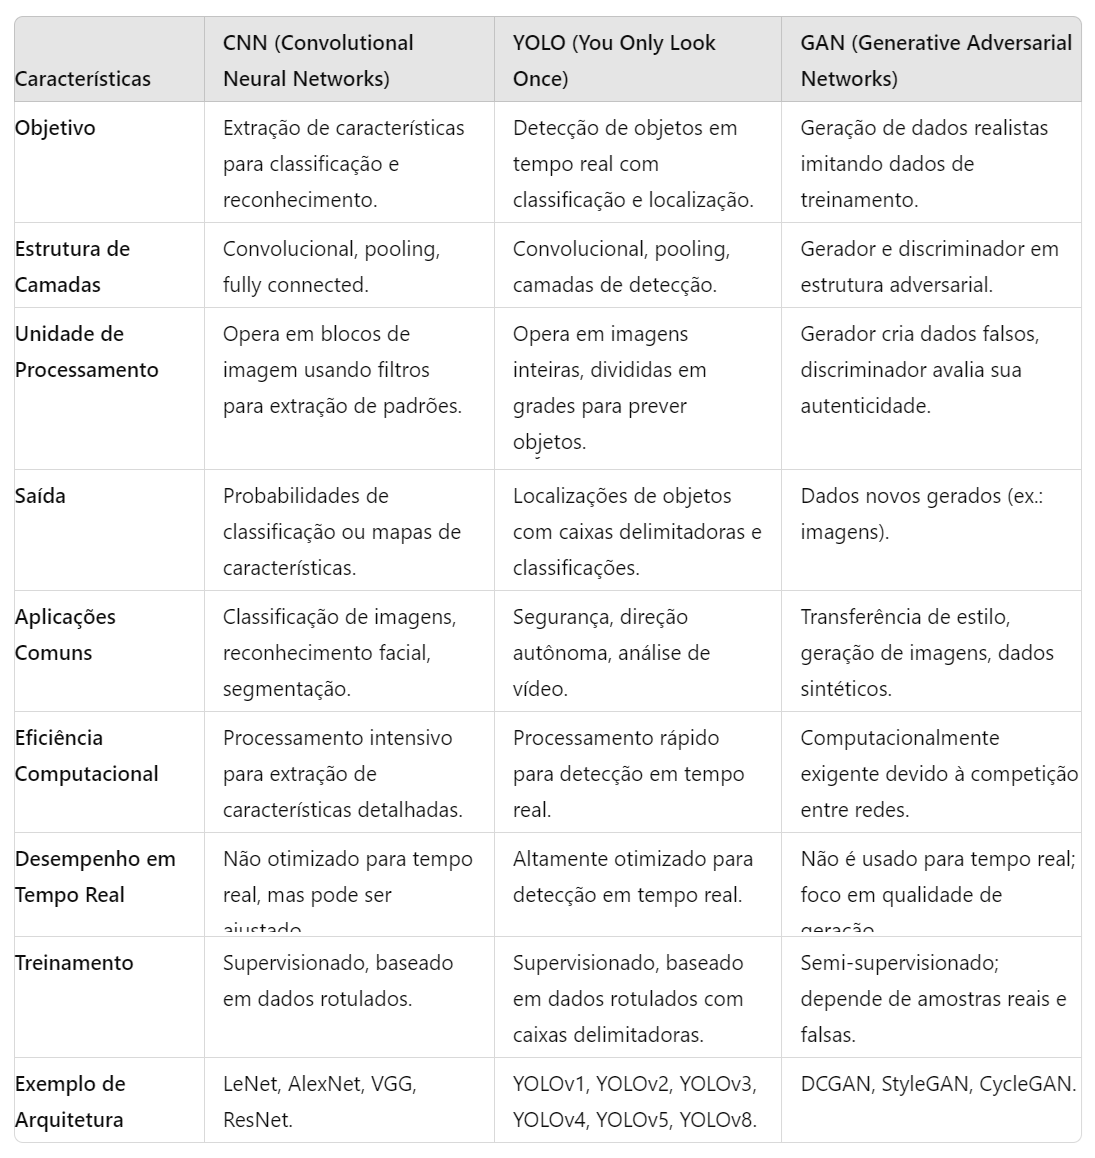